# sierraleone EDA Notebook — Solar Challenge

This notebook performs end-to-end exploratory data analysis (EDA), data profiling, and basic cleaning on the sierraleone  solar dataset. The goal is to prepare the data for comparison and region-ranking tasks in the Solar Challenge.

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

sns.set(style="whitegrid")

In [3]:
# Modular EDA Class
class SolarEDA:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def summarize_data(self):
        display(self.df.describe())
        print("\nMissing values per column:")
        print(self.df.isna().sum())

    def flag_high_nulls(self, threshold=0.05):
        null_percent = self.df.isna().mean()
        print("Columns with >5% missing values:")
        print(null_percent[null_percent > threshold])

    def impute_missing(self, cols):
        """
        Impute missing values in specified columns using median.
    
        Args:
            cols (list of str): Columns to impute.
        """
        for col in cols:
            if col in self.df.columns:
                median_value = self.df[col].median()
                self.df[col] = self.df[col].fillna(median_value)
        print("Missing values imputed with median.")


    def detect_outliers(self, cols, threshold=3):
        zs = zscore(self.df[cols].dropna(), nan_policy='omit')
        mask = (np.abs(zs) > threshold).any(axis=1)
        return self.df.loc[mask]

    def remove_outliers(self, cols, threshold=3):
        zs = zscore(self.df[cols].dropna(), nan_policy='omit')
        mask = (np.abs(zs) < threshold).all(axis=1)
        self.df = self.df.loc[mask.index[mask]]

    def plot_timeseries(self, cols):
        self.df.set_index("Timestamp", inplace=True)
        for col in cols:
            self.df[col].plot(figsize=(10, 3), title=f"{col} over time")
            plt.ylabel(col)
            plt.show()
        self.df.reset_index(inplace=True)

    def correlation_heatmap(self, cols):
        corr = self.df[cols].corr()
        sns.heatmap(corr, annot=True, cmap="coolwarm")
        plt.title("Correlation Heatmap")
        plt.show()

    def plot_cleaning_impact(self):
        if "Cleaning" in self.df.columns:
            mod_means = self.df.groupby("Cleaning")[["ModA", "ModB"]].mean()
            mod_means.plot(kind="bar")
            plt.title("ModA and ModB before/after cleaning")
            plt.show()
            
    def flag_outliers(df, columns):
        """
        Compute Z-scores for given columns and flag rows with |Z| > 3 as outliers.
        Returns a DataFrame with an added boolean column 'Outlier' for flagged rows.
        """
        z_scores = df[columns].apply(zscore, nan_policy='omit')  # ignore NaNs in zscore calc
        outlier_mask = (z_scores.abs() > 3).any(axis=1)  # any column with |z|>3
        df['Outlier'] = outlier_mask
        return df
    
    def handle_missing_values(df, key_columns):
        """
        Drop or impute (median) missing values in key columns.
        Here, we impute median for missing values.
        """
        for col in key_columns:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
        return df

In [4]:
# Loading and Exploring the Data
df = pd.read_csv("sierraleone-bumbuna.csv", parse_dates=["Timestamp"])
eda = SolarEDA(df)

In [5]:
# Summary Statistics & Missing Values
eda.summarize_data()
eda.flag_high_nulls()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-30 12:00:30.000000768,201.957515,116.376337,113.720571,206.643095,198.114691,26.319394,79.448857,1.146113,1.691606,0.363823,133.044668,7.172220,999.876469,0.000967,0.004806,32.504263,32.593091,NaN
min,2021-10-30 00:01:00,-19.500000,-7.800000,-17.900000,0.000000,0.000000,12.300000,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,993.000000,0.000000,0.000000,10.700000,11.100000,NaN
25%,2022-01-29 06:00:45,-2.800000,-0.300000,-3.800000,0.000000,0.000000,23.100000,68.700000,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,0.000000,23.500000,23.800000,NaN
50%,2022-04-30 12:00:30,0.300000,-0.100000,-0.100000,3.600000,3.400000,25.300000,85.400000,0.800000,1.600000,0.400000,161.500000,6.200000,1000.000000,0.000000,0.000000,26.600000,26.900000,NaN
75%,2022-07-30 18:00:15,362.400000,107.000000,224.700000,359.500000,345.400000,29.400000,96.700000,2.000000,2.600000,0.600000,234.100000,12.000000,1001.000000,0.000000,0.000000,40.900000,41.300000,NaN
max,2022-10-30 00:00:00,1499.000000,946.000000,892.000000,1507.000000,1473.000000,39.900000,100.000000,19.200000,23.900000,4.100000,360.000000,98.400000,1006.000000,1.000000,2.400000,72.800000,70.400000,NaN
std,NaN,298.495150,218.652659,158.946032,300.896893,288.889073,4.398605,20.520775,1.239248,1.617053,0.295000,114.284792,7.535093,2.104419,0.031074,0.047556,12.434899,12.009161,NaN



Missing values per column:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64
Columns with >5% missing values:
Comments    1.0
dtype: float64


In [6]:
df[["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]].isna().sum()

GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64

In [7]:
def flag_outliers(df, columns):
    """
    Computes Z-scores for specified columns and flags rows as outliers
    if any column has |Z| > 3.
    """
    z_scores = df[columns].apply(zscore, nan_policy='omit')
    df['Outlier'] = (z_scores.abs() > 3).any(axis=1)
    return df

def handle_missing_values(df, columns):
    """
    Fills missing values in specified columns with their median.
    """
    for col in columns:
        if df[col].isnull().sum() > 0:
            median = df[col].median()
            df[col].fillna(median, inplace=True)
    return df
    
# Define the columns to check
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Flag outliers
eda.df = flag_outliers(eda.df, key_cols)

# Handle missing values by median imputation
eda.df = handle_missing_values(eda.df, key_cols)

# Show summary
print(f"Number of outlier rows flagged: {eda.df['Outlier'].sum()}")
print("Missing values after imputation:\n", eda.df[key_cols].isna().sum())

Number of outlier rows flagged: 16292
Missing values after imputation:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


In [8]:
eda.impute_missing(["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"])

Missing values imputed with median.


In [9]:
# Detect and Remove Outliers
outliers = eda.detect_outliers(["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"])
print(f"Outliers found: {len(outliers)}")

eda.remove_outliers(["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"])

Outliers found: 16292


In [10]:
# Export Cleaned Dataset (Do NOT Commit This)
eda.df.to_csv("data/benin_clean.csv", index=False)

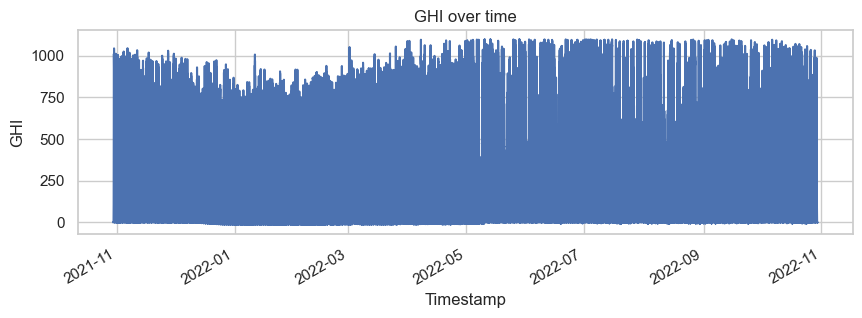

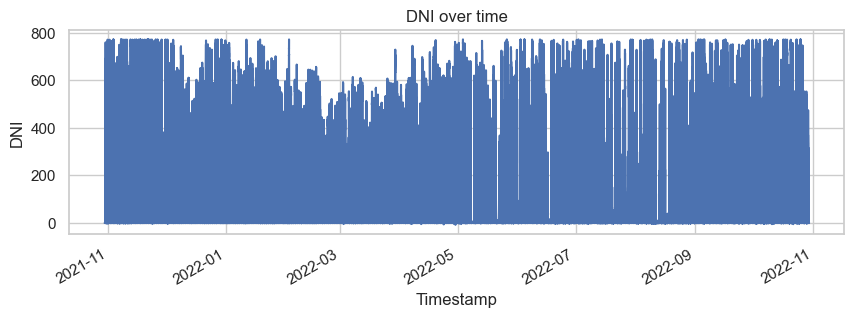

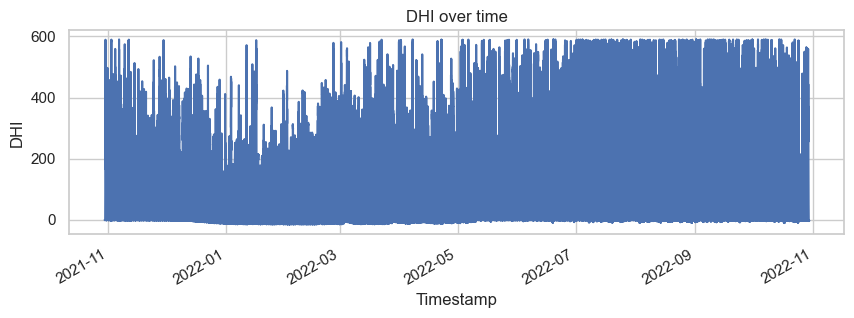

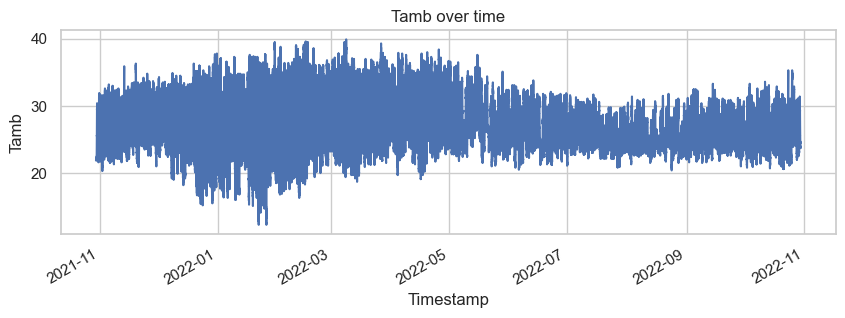

In [11]:
#Time Series Plots of Solar Parameters
eda.plot_timeseries(["GHI", "DNI", "DHI", "Tamb"])

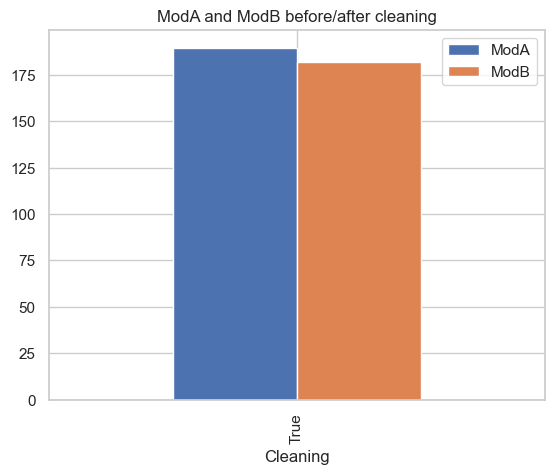

In [14]:
# Cleaning Impact on ModA and ModB
eda.df["Cleaning"] = df.isna().any(axis=1)
eda.plot_cleaning_impact()

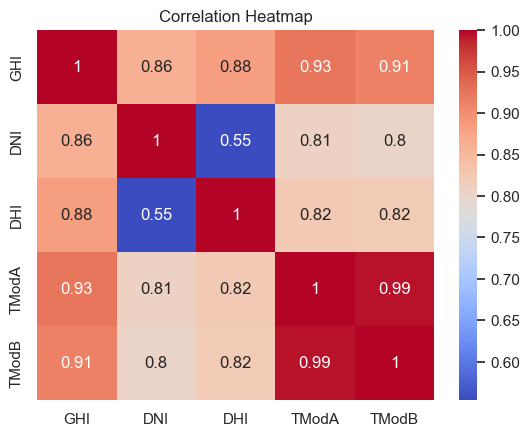

In [15]:
# Correlation Heatmap
eda.correlation_heatmap(["GHI", "DNI", "DHI", "TModA","TModB"])

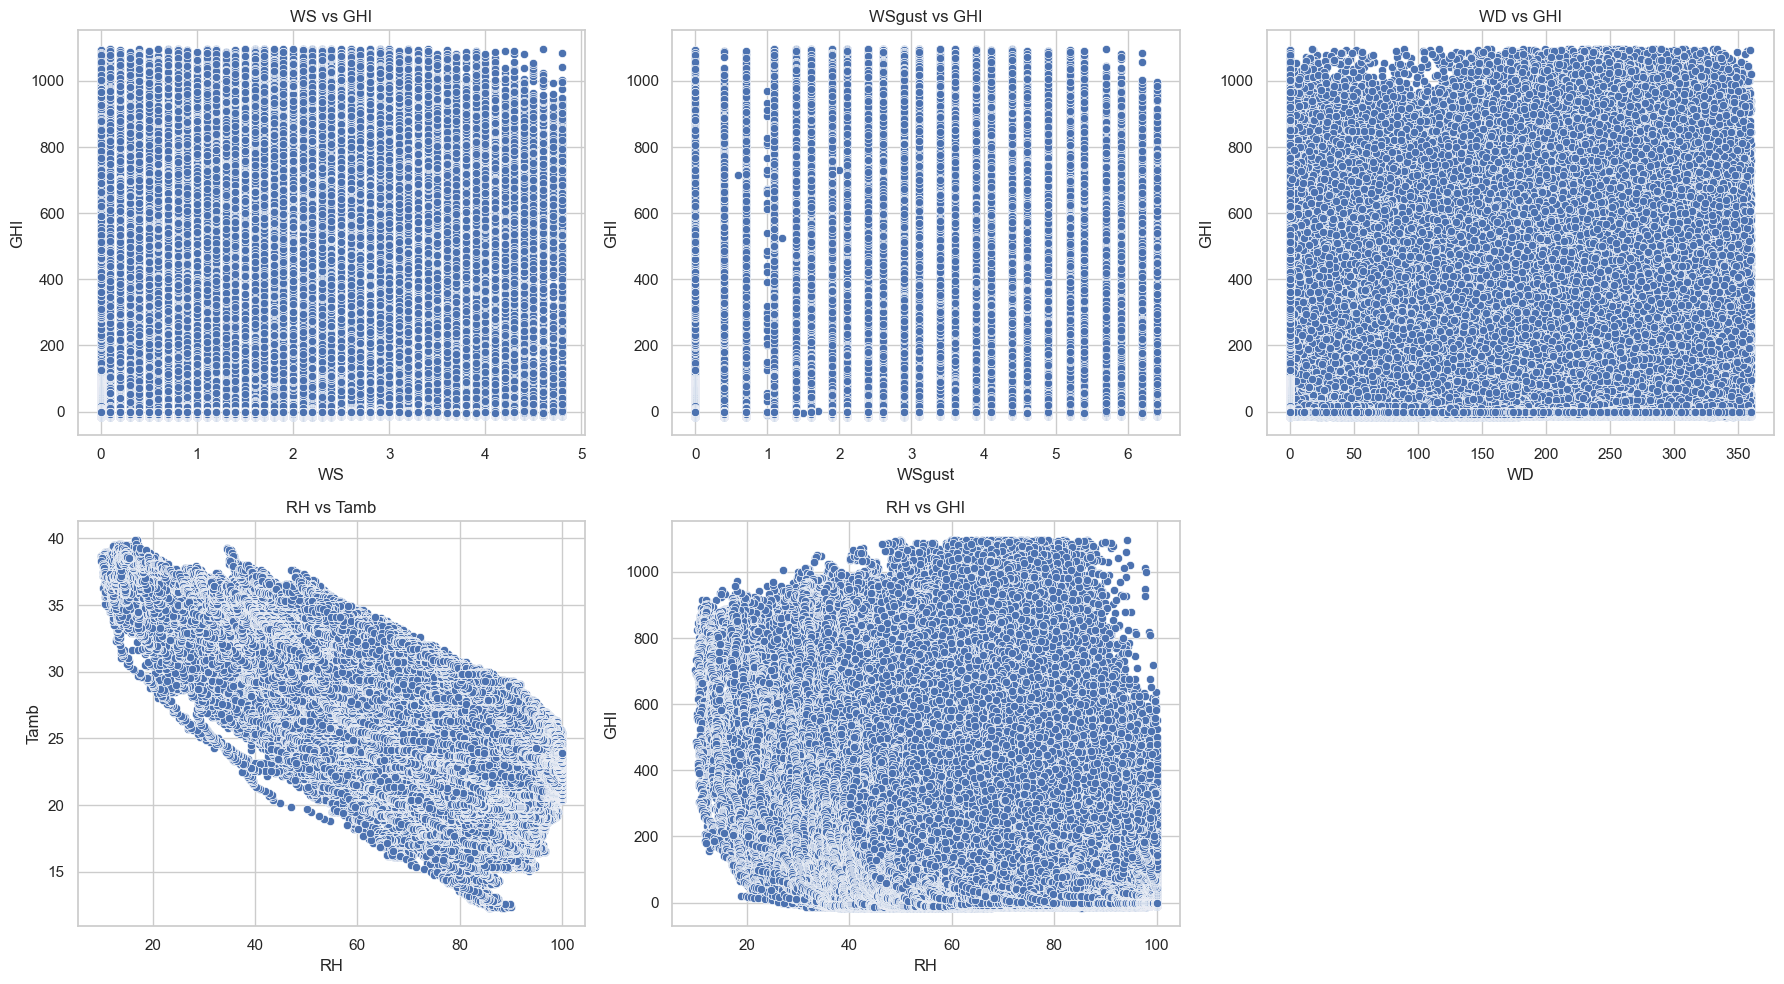

In [16]:
# Scatter Plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI
def scatter_plots(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    sns.scatterplot(x="WS", y="GHI", data=df, ax=axes[0, 0]).set_title("WS vs GHI")
    sns.scatterplot(x="WSgust", y="GHI", data=df, ax=axes[0, 1]).set_title("WSgust vs GHI")
    sns.scatterplot(x="WD", y="GHI", data=df, ax=axes[0, 2]).set_title("WD vs GHI")
    sns.scatterplot(x="RH", y="Tamb", data=df, ax=axes[1, 0]).set_title("RH vs Tamb")
    sns.scatterplot(x="RH", y="GHI", data=df, ax=axes[1, 1]).set_title("RH vs GHI")
    # Empty subplot
    axes[1, 2].axis('off')
    plt.tight_layout()
    plt.show()

scatter_plots(eda.df)

C:\Users\Mewal\AppData\Local\Temp\ipykernel_17280\3559761367.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ws_means = df.groupby('WD_bin')['WS'].mean().fillna(0)


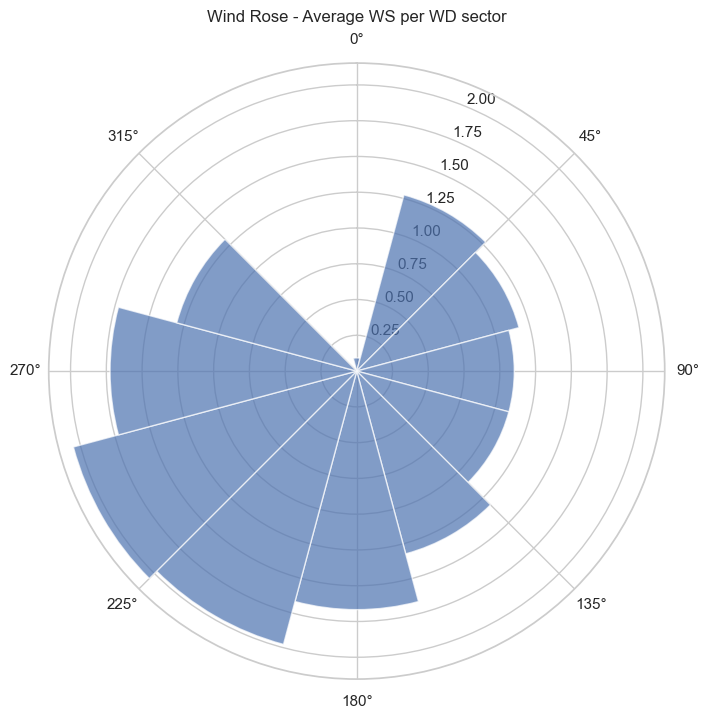

In [17]:
# Wind & Distribution Analysis
### Wind Rose or Radial Bar Plot of WS and WD
# Wind rose requires polar plotting - simplified radial bar plot example:

def wind_rose(df):
    wd_bins = np.arange(0, 360, 30)  # 12 sectors, 30° each
    df['WD_bin'] = pd.cut(df['WD'], bins=wd_bins, right=False, labels=wd_bins[:-1])

    ws_means = df.groupby('WD_bin')['WS'].mean().fillna(0)

    angles = np.deg2rad(ws_means.index.astype(float))
    radii = ws_means.values

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)
    bars = ax.bar(angles, radii, width=np.deg2rad(30), bottom=0.0, alpha=0.7)

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_title('Wind Rose - Average WS per WD sector', va='bottom')
    plt.show()

wind_rose(eda.df)

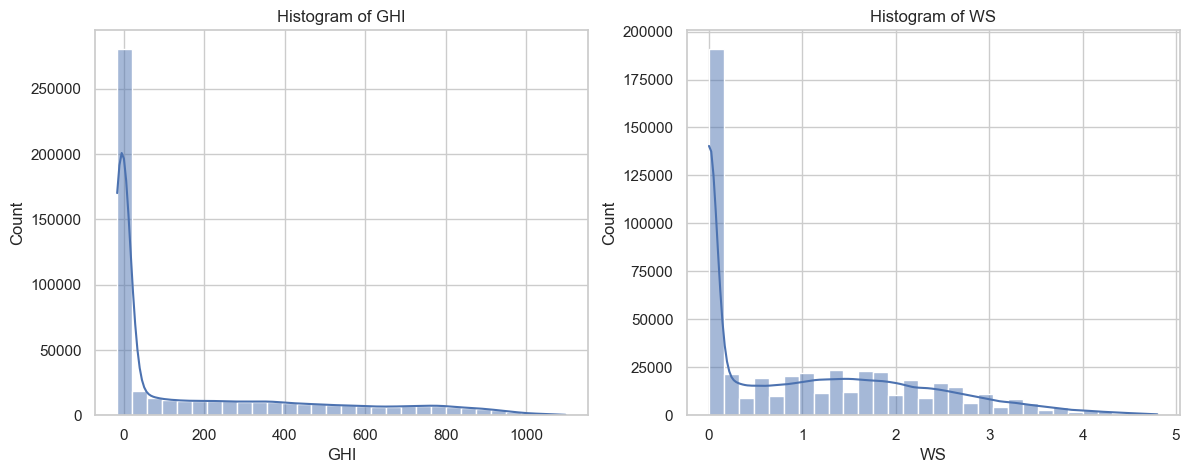

In [18]:
# Histograms for GHI and WS
def plot_histograms(df):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    sns.histplot(df['GHI'], bins=30, kde=True, ax=axes[0]).set_title("Histogram of GHI")
    sns.histplot(df['WS'], bins=30, kde=True, ax=axes[1]).set_title("Histogram of WS")
    plt.show()

plot_histograms(eda.df)

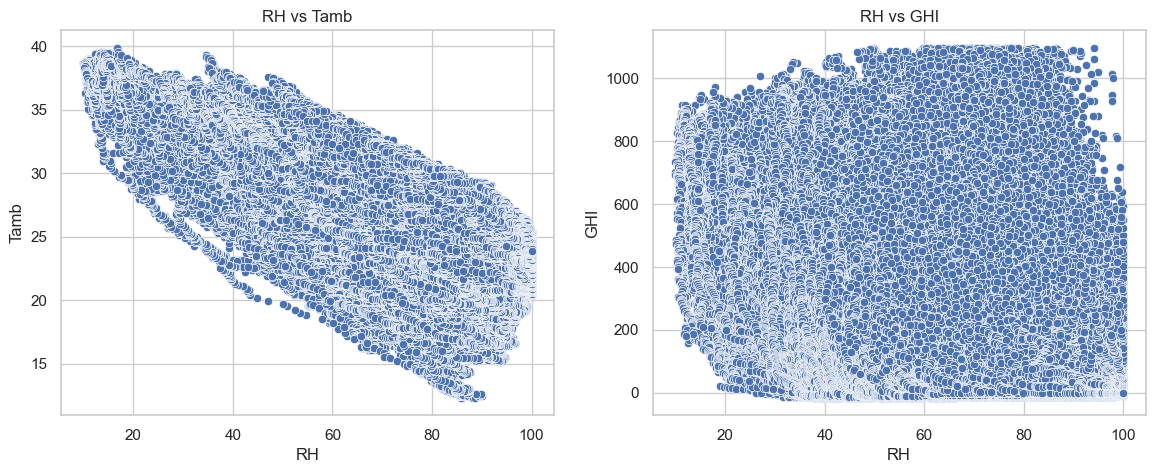

In [19]:
# 13. Temperature Analysis: Impact of Relative Humidity (RH) on Temperature and Solar Radiation
def temp_rh_analysis(df):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    sns.scatterplot(x="RH", y="Tamb", data=df, ax=axes[0]).set_title("RH vs Tamb")
    sns.scatterplot(x="RH", y="GHI", data=df, ax=axes[1]).set_title("RH vs GHI")
    plt.show()

temp_rh_analysis(eda.df)

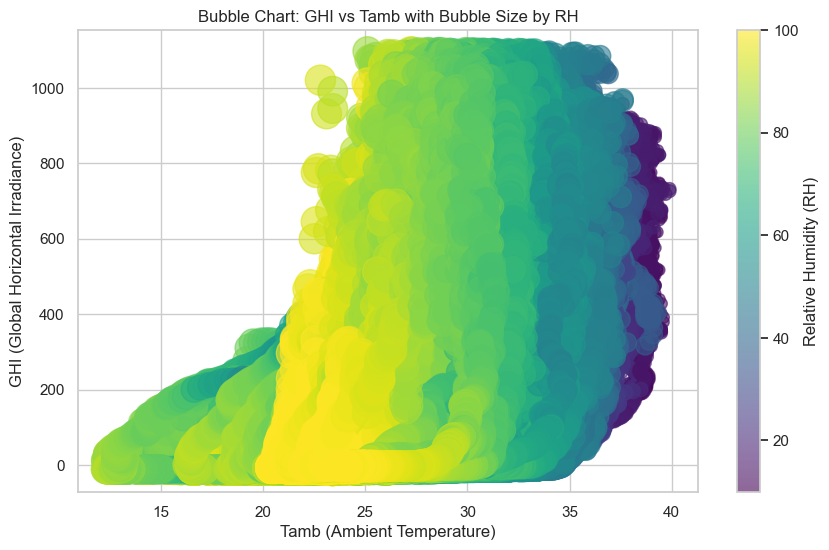

In [20]:
#Bubble Chart: GHI vs Tamb with Bubble Size = RH
def bubble_chart(df):
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df['Tamb'], df['GHI'], s=df['RH']*5, c=df['RH'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Relative Humidity (RH)')
    plt.xlabel('Tamb (Ambient Temperature)')
    plt.ylabel('GHI (Global Horizontal Irradiance)')
    plt.title('Bubble Chart: GHI vs Tamb with Bubble Size by RH')
    plt.show()

bubble_chart(eda.df)